In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import warnings

# Ignore warnings for a clean output
warnings.filterwarnings('ignore')


In [ ]:
# Load the dataset from Google Drive
data_path = '/content/combined_autism_dataset_with_genetic_data (1).csv'
data_fin = pd.read_csv(data_path)

# Display the first few rows of the dataset
data_fin.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,early_motor_development_delay,speech_delay,eye_contact_issues,hypersensitivity_to_sensory_stimuli,immune_system_issues,brain_structure_anomaly,SNP1_risk_variant,SNP2_risk_variant,family_member_with_ASD_genetic_marker,chromosomal_abnormality_present
0,0,0,0,0,0,0,1,1,0,1,...,yes,yes,yes,no,no,yes,absent,present,no,yes
1,1,1,0,0,0,1,1,0,0,0,...,no,no,yes,no,yes,no,absent,absent,yes,yes
2,1,0,0,0,0,0,1,1,0,1,...,yes,yes,yes,no,no,no,present,absent,no,no
3,1,1,1,1,1,1,1,1,1,1,...,yes,yes,yes,yes,no,no,present,present,no,yes
4,1,1,0,1,1,1,1,1,1,1,...,no,yes,yes,yes,yes,yes,present,absent,no,no


In [ ]:
# Display information about dataset columns and data types
print(data_fin.info())

# Check for missing values
missing_values = pd.DataFrame(data_fin.isnull().sum(), columns=["Missing Values"])
print(missing_values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1758 entries, 0 to 1757
Data columns (total 39 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   A1_Score                                  1758 non-null   int64  
 1   A2_Score                                  1758 non-null   int64  
 2   A3_Score                                  1758 non-null   int64  
 3   A4_Score                                  1758 non-null   int64  
 4   A5_Score                                  1758 non-null   int64  
 5   A6_Score                                  1758 non-null   int64  
 6   A7_Score                                  1758 non-null   int64  
 7   A8_Score                                  1758 non-null   int64  
 8   A9_Score                                  1758 non-null   int64  
 9   A10_Score                                 1758 non-null   int64  
 10  Age_Mons                            

In [ ]:
# Display column names to verify their actual names in the dataset
print(data_fin.columns)

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'Age_Mons',
       'Qchat-10-Score', 'gender', 'ethnicity', 'jundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD', 'age',
       'austim', 'contry_of_res', 'result', 'age_desc', 'relation',
       'family_history_of_neurological_disorders', 'genetic_marker_risk',
       'blood_oxygen_level', 'vitamin_d_level', 'prenatal_complications',
       'early_motor_development_delay', 'speech_delay', 'eye_contact_issues',
       'hypersensitivity_to_sensory_stimuli', 'immune_system_issues',
       'brain_structure_anomaly', 'SNP1_risk_variant', 'SNP2_risk_variant',
       'family_member_with_ASD_genetic_marker',
       'chromosomal_abnormality_present'],
      dtype='object')


In [ ]:
# Define the list of expected categorical columns based on available column names
categorical_cols = [col for col in ['Ethnicity', 'Who_completed_the_test', 'Sex', 'Jaundice', 'Family_mem_with_ASD', 'ASD_traits'] if col in data_fin.columns]

# Fill missing values for categorical columns with the mode, only if they exist in the dataset
for col in categorical_cols:
    data_fin[col].fillna(data_fin[col].mode()[0], inplace=True)

# For numerical columns, fill missing values with the mean
numerical_cols = data_fin.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    data_fin[col].fillna(data_fin[col].mean(), inplace=True)

# Verify that there are no missing values left
print(data_fin.isnull().sum())


A1_Score                                       0
A2_Score                                       0
A3_Score                                       0
A4_Score                                       0
A5_Score                                       0
A6_Score                                       0
A7_Score                                       0
A8_Score                                       0
A9_Score                                       0
A10_Score                                      0
Age_Mons                                       0
Qchat-10-Score                                 0
gender                                         0
ethnicity                                      0
jundice                                        0
Family_mem_with_ASD                            0
Who completed the test                       704
Class/ASD                                      0
age                                            0
austim                                      1054
contry_of_res       

In [ ]:
# Define replacements for categorical columns to standardize values
replacements = {
    'Sex': {'f': 'F', 'm': 'M'},
    'Jaundice': {'yes': 'Yes', 'no': 'No'},
    'Family_mem_with_ASD': {'yes': 'Yes', 'no': 'No'},
    'ASD_traits': {'YES': 'Yes', 'NO': 'No'},
    'Ethnicity': {
        'middle eastern': 'Middle Eastern', 'Middle Eastern ': 'Middle Eastern',
        'mixed': 'Mixed', 'asian': 'Asian', 'black': 'Black',
        'south asian': 'South Asian', 'PaciFica':'Pacifica', 'Pasifika':'Pacifica'
    },
    'Who_completed_the_test': {
        'Health care professional':'Health Care Professional',
        'family member':'Family Member', 'Family member':'Family Member'
    }
}

# Apply replacements to each column, if the column exists in the dataset
for col, replace_dict in replacements.items():
    if col in data_fin.columns:
        data_fin[col] = data_fin[col].replace(replace_dict)

# Initialize LabelEncoder and encode categorical columns
# This part checks that the column exists before applying encoding
le = LabelEncoder()
for col in categorical_cols:
    if col in data_fin.columns:
        data_fin[col] = le.fit_transform(data_fin[col])

# Display the first few rows to verify changes
data_fin.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,early_motor_development_delay,speech_delay,eye_contact_issues,hypersensitivity_to_sensory_stimuli,immune_system_issues,brain_structure_anomaly,SNP1_risk_variant,SNP2_risk_variant,family_member_with_ASD_genetic_marker,chromosomal_abnormality_present
0,0,0,0,0,0,0,1,1,0,1,...,yes,yes,yes,no,no,yes,absent,present,no,yes
1,1,1,0,0,0,1,1,0,0,0,...,no,no,yes,no,yes,no,absent,absent,yes,yes
2,1,0,0,0,0,0,1,1,0,1,...,yes,yes,yes,no,no,no,present,absent,no,no
3,1,1,1,1,1,1,1,1,1,1,...,yes,yes,yes,yes,no,no,present,present,no,yes
4,1,1,0,1,1,1,1,1,1,1,...,no,yes,yes,yes,yes,yes,present,absent,no,no


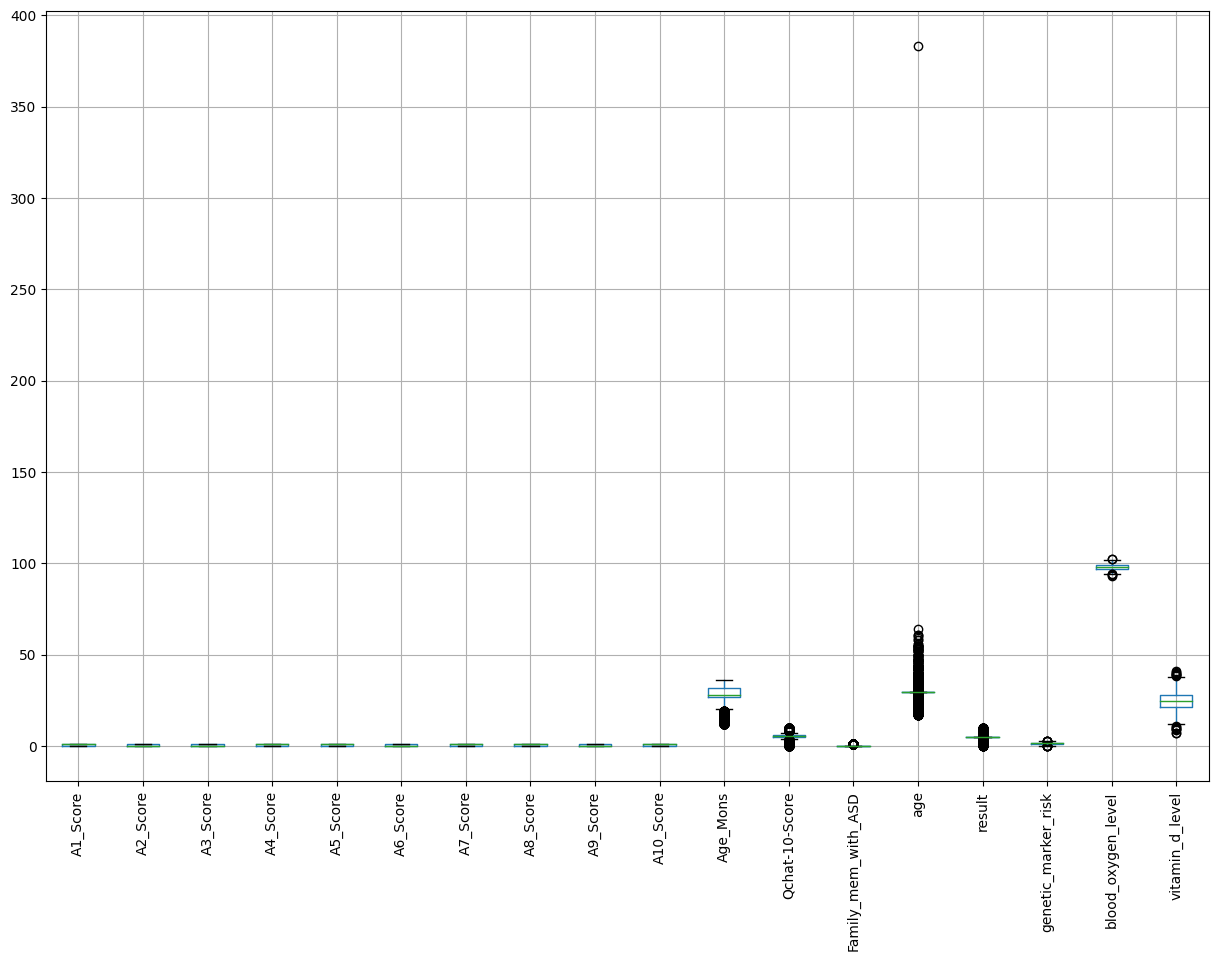

In [ ]:
# Redefine numerical columns by selecting only columns of type int or float
numerical_cols = data_fin.select_dtypes(include=['float64', 'int64']).columns

# Plot boxplots for numerical columns to inspect potential outliers
plt.figure(figsize=(15, 10))
data_fin[numerical_cols].boxplot()  # Use only the numerical columns
plt.xticks(rotation=90)
plt.show()

In [ ]:
print(data_fin.columns)

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'Age_Mons',
       'Qchat-10-Score', 'gender', 'ethnicity', 'jundice',
       'Family_mem_with_ASD', 'Who completed the test', 'Class/ASD', 'age',
       'austim', 'contry_of_res', 'result', 'age_desc', 'relation',
       'family_history_of_neurological_disorders', 'genetic_marker_risk',
       'blood_oxygen_level', 'vitamin_d_level', 'prenatal_complications',
       'early_motor_development_delay', 'speech_delay', 'eye_contact_issues',
       'hypersensitivity_to_sensory_stimuli', 'immune_system_issues',
       'brain_structure_anomaly', 'SNP1_risk_variant', 'SNP2_risk_variant',
       'family_member_with_ASD_genetic_marker',
       'chromosomal_abnormality_present'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import pandas as pd

# Step 7.1: Separate Features and Target before encoding
# This ensures 'X' is defined before use
X = data_fin.drop(columns=["Class/ASD"])  # Replace "Class/ASD" if needed
y = data_fin["Class/ASD"]

# Step 7.2: Encode Categorical Columns
# Identify categorical columns that need encoding
categorical_cols = X.select_dtypes(include=['object']).columns

# Apply LabelEncoder to each categorical column
le = LabelEncoder()
for col in categorical_cols:
    # Use X instead of data_fin for consistency
    X[col] = le.fit_transform(X[col])

# Step 7.3: Scale the Features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert scaled data back to DataFrame for easier readability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.23, random_state=45)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)

    # Change to 'weighted' or 'macro' as appropriate
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Create a DataFrame to display metrics
    score_df = pd.DataFrame([[accuracy, precision, recall, f1]],
                            columns=["Accuracy", "Precision", "Recall", "F1 Score"])
    return score_df

# Example with Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
results = train_model(model, x_train, y_train, x_test, y_test)
print("Logistic Regression Results:\n", results)


Logistic Regression Results:
    Accuracy  Precision    Recall  F1 Score
0  0.997531   0.997591  0.997531  0.997541


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define Random Forest and parameter grid for tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'n_estimators': [10, 50, 100, 200]
}

# Grid search for best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=4, n_jobs=-1, verbose=1, scoring="accuracy")
grid_search.fit(x_train, y_train)

# Retrieve the best model from grid search
rf_best = grid_search.best_estimator_
print("Best Random Forest Model:", rf_best)
print("Best Score from Grid Search:", grid_search.best_score_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best Random Forest Model: RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=50,
                       n_jobs=-1, random_state=42)
Best Score from Grid Search: 1.0


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict and evaluate using the best model
y_pred = rf_best.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

          NO       1.00      1.00      1.00       122
          No       1.00      1.00      1.00        78
         YES       1.00      1.00      1.00        40
         Yes       1.00      1.00      1.00       165

    accuracy                           1.00       405
   macro avg       1.00      1.00      1.00       405
weighted avg       1.00      1.00      1.00       405

Confusion Matrix:
 [[122   0   0   0]
 [  0  78   0   0]
 [  0   0  40   0]
 [  0   0   0 165]]


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Assuming y_train and y_test are your target variables
# Convert labels to binary if they're in string format
y_train = np.where(y_train == "YES", 1, 0)
y_test = np.where(y_test == "YES", 1, 0)

# Define a neural network model
nn_model = Sequential([
    Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Single output for binary classification
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the neural network model
history = nn_model.fit(x_train, y_train, validation_split=0.2, epochs=100, callbacks=[early_stopping], batch_size=32)

# Evaluate neural network model
nn_eval = nn_model.evaluate(x_test, y_test)
print(f"Neural Network Accuracy: {nn_eval[1]:.2f}")


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8694 - loss: 0.4867 - val_accuracy: 0.8745 - val_loss: 0.3805
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8943 - loss: 0.3061 - val_accuracy: 0.8745 - val_loss: 0.2474
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9140 - loss: 0.1866 - val_accuracy: 0.9557 - val_loss: 0.1390
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9474 - loss: 0.1258 - val_accuracy: 0.9631 - val_loss: 0.0905
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9645 - loss: 0.0925 - val_accuracy: 0.9742 - val_loss: 0.0638
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9777 - loss: 0.0700 - val_accuracy: 0.9631 - val_loss: 0.0771
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9836 - loss: 0.0533 - val_accuracy: 0.9779 - val_loss: 0.0490
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9846 - loss: 0.0408 - val_accuracy: 0.9815 - 

In [ ]:
from sklearn.svm import SVC

# Initialize the model
svm_model = SVC(kernel='linear', random_state=42)

# Fit the model
svm_model.fit(x_train, y_train)

# Make predictions
y_pred = svm_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


SVM Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       365
           1       1.00      1.00      1.00        40

    accuracy                           1.00       405
   macro avg       1.00      1.00      1.00       405
weighted avg       1.00      1.00      1.00       405



In [ ]:
import xgboost as xgb

# Initialize the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Fit the model
xgb_model.fit(x_train, y_train)

# Make predictions
y_pred = xgb_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

XGBoost Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       365
           1       1.00      1.00      1.00        40

    accuracy                           1.00       405
   macro avg       1.00      1.00      1.00       405
weighted avg       1.00      1.00      1.00       405



KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize the model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn_model.fit(x_train, y_train)

# Make predictions
y_pred = knn_model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"KNN Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))


KNN Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       365
           1       0.87      0.82      0.85        40

    accuracy                           0.97       405
   macro avg       0.92      0.91      0.91       405
weighted avg       0.97      0.97      0.97       405



Cross Validation

In [ ]:

from sklearn.model_selection import cross_val_score

# Example for Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
cv_scores = cross_val_score(rf_model, x_train, y_train, cv=5)
print(f"Random Forest CV Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")


Random Forest CV Accuracy: 1.00 ± 0.00


Train and Evaluate Each Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),  # Set probability=True for ROC AUC if needed
    "XGBoost": XGBClassifier(),
    "KNN": KNeighborsClassifier()
}

# Dictionary to hold metrics
metrics = {}

# Train and evaluate each model
for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multiclass
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store metrics
    metrics[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }


Results Datframe

In [ ]:
# Convert metrics dictionary to DataFrame
results = pd.DataFrame(metrics).T  # Transpose to get models as rows
print(results)


                     Accuracy  Precision    Recall  F1 Score
Logistic Regression  0.992593   0.992706  0.992593  0.992633
Random Forest        1.000000   1.000000  1.000000  1.000000
SVM                  0.990123   0.990231  0.990123  0.989890
XGBoost              1.000000   1.000000  1.000000  1.000000
KNN                  0.970370   0.969815  0.970370  0.970031


Using Cross Validation with Scikit-learn

In [ ]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'KNN': KNeighborsClassifier()
}

# Initialize a list to hold results
results_list = []

# Evaluate each model using cross-validation
for model_name, model in models.items():
    # Cross-validated accuracy
    accuracies = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    accuracy = accuracies.mean()

    # Fit the model and predict to get other metrics
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)

    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Append results to the list
    results_list.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Create a DataFrame from the results list
results = pd.DataFrame(results_list)

# Display the results
print(results)

                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.989651   0.992706  0.992593  0.992633
1        Random Forest  1.000000   1.000000  1.000000  1.000000
2                  SVM  0.987429   0.990231  0.990123  0.989890
3              XGBoost  1.000000   1.000000  1.000000  1.000000
4                  KNN  0.974859   0.969815  0.970370  0.970031
